In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/staircase dataset.zip" -d "/content/staircase_dataset"

Archive:  /content/drive/MyDrive/staircase dataset.zip
   creating: /content/staircase_dataset/StaircaseDetection/images/
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_1.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_1_a1.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_1_a2.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_1_a3.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_1_a4.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_1_a5.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_2.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_2_a1.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_2_a2.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_2_a3.jpg  
  inflating: /content/staircase_dataset/StaircaseDetection/images/1_2_a4.jpg  
  inflating: /c

In [5]:
import os

dataset_path = "/content/staircase_dataset/StaircaseDetection"
print("Files in dataset folder:")
print(os.listdir(dataset_path))

Files in dataset folder:
['train.txt', 'val.txt', 'images', 'labels']


In [6]:
images_dir = "/content/staircase_dataset/StaircaseDetection/images"
labels_dir = "/content/staircase_dataset/StarcaseDetection/labels"
train_list = "/content/staircase_dataset/StaircaseDetection/train.txt"
val_list = "/content/staircase_dataset/StaircaseDetection/val.txt"

In [7]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [8]:
!pip install torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [9]:
pip install opencv-python-headless pycocotools

In [22]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-6faqfplk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-6faqfplk
  Resolved https://github.com/facebookresearch/detectron2.git to commit d38d7161247e64276d4c44d9d0605291e80bd969
  Preparing metadata (setup.py) ... done


In [10]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

print("Detectron2 is ready to roll on CPU.")

Detectron2 is ready to roll on CPU.


In [11]:
import os

image_dir = "/content/staircase_dataset/StaircaseDetection/images"
output_txt = "/content/staircase_dataset/StaircaseDetection/train.txt"

# List all image files (you can filter by extension if needed)
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Write to train.txt
with open(output_txt, "w") as f:
    for img in image_files:
        f.write(img + "\n")

print(f"✅ Regenerated train.txt with {len(image_files)} entries.")

✅ Regenerated train.txt with 444 entries.


In [12]:
import os

val_image_dir = "/content/staircase_dataset/StaircaseDetection/images"
val_txt_path = "/content/staircase_dataset/StaircaseDetection/val.txt"

# List all image files (filtering by extension)
val_image_files = [f for f in os.listdir(val_image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Write to val.txt
with open(val_txt_path, "w") as f:
    for img in val_image_files:
        f.write(img + "\n")

print(f"✅ Regenerated val.txt with {len(val_image_files)} entries.")

✅ Regenerated val.txt with 444 entries.


In [24]:
import os
import json
from PIL import Image

def convert_yolo_to_coco(txt_path, image_dir, label_dir, output_json, category_name="staircase", start_image_id=0, start_ann_id=0):
    with open(txt_path, 'r') as f:
        image_files = [line.strip() for line in f.readlines()]

    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 0, "name": category_name}]
    }

    image_id = start_image_id
    ann_id = start_ann_id

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")

        if not os.path.exists(img_path) or not os.path.exists(label_path):
            continue

        try:
            width, height = Image.open(img_path).size
        except:
            continue

        coco["images"].append({
            "id": image_id,
            "file_name": img_path,
            "width": width,
            "height": height
        })

        with open(label_path, 'r') as lf:
            for line in lf:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue

                cls, x_center, y_center, w, h = map(float, parts)
                x = (x_center - w / 2) * width
                y = (y_center - h / 2) * height
                box_w = w * width
                box_h = h * height

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": int(cls),
                    "bbox": [x, y, box_w, box_h],
                    "area": box_w * box_h,
                    "iscrowd": 0
                })
                ann_id += 1

        image_id += 1

    with open(output_json, 'w') as out_file:
        json.dump(coco, out_file)
    print(f"✅ Saved COCO annotations to: {output_json}")

In [25]:
# Train set
convert_yolo_to_coco(
    txt_path="/content/staircase_dataset/StaircaseDetection/train.txt",
    image_dir="/content/staircase_dataset/StaircaseDetection/images",
    label_dir="/content/staircase_dataset/StaircaseDetection/labels",
    output_json="/content/staircase_dataset/StaircaseDetection/train_coco.json"
)

# Validation set
convert_yolo_to_coco(
    txt_path="/content/staircase_dataset/StaircaseDetection/val.txt",
    image_dir="/content/staircase_dataset/StaircaseDetection/images",
    label_dir="/content/staircase_dataset/StaircaseDetection/labels",
    output_json="/content/staircase_dataset/StaircaseDetection/val_coco.json",
    start_image_id=10000,  # Avoid ID collisions
    start_ann_id=100000
)

✅ Saved COCO annotations to: /content/staircase_dataset/StaircaseDetection/train_coco.json
✅ Saved COCO annotations to: /content/staircase_dataset/StaircaseDetection/val_coco.json


In [26]:
import json

with open("/content/staircase_dataset/StaircaseDetection/train_coco.json") as f:
    data = json.load(f)

print("Sample image path:", data["images"][0]["file_name"])

Sample image path: /content/staircase_dataset/StaircaseDetection/images/t4_2_a3.jpg


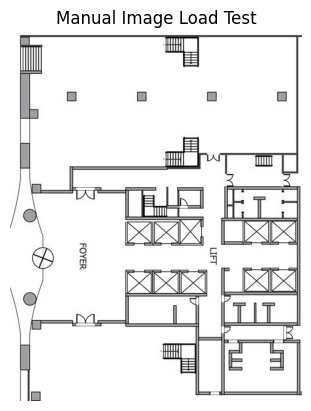

In [27]:
import cv2
import matplotlib.pyplot as plt

img_path = data["images"][0]["file_name"]
img = cv2.imread(img_path)

if img is None:
    print("❌ Image not found or unreadable.")
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Manual Image Load Test")
    plt.show()

In [19]:
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name = "staircase_train"

if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)
    print(f"✅ Removed old registration: {dataset_name}")

dataset_name = "staircase_val"

if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)
    print(f"✅ Removed old registration: {dataset_name}")

✅ Removed old registration: staircase_train
✅ Removed old registration: staircase_val


In [20]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances(
    "staircase_train",
    {},
    "/content/staircase_dataset/StaircaseDetection/train_coco.json",
    "/content/staircase_dataset/StaircaseDetection/images"
)
register_coco_instances(
    "staircase_val",
    {},
    "/content/staircase_dataset/StaircaseDetection/val_coco.json",
    "/content/staircase_dataset/StaircaseDetection/images"
)


In [28]:
from detectron2.data import DatasetCatalog

print("Registered datasets:", DatasetCatalog.list())

Registered datasets: ['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5_train_cocofied', 'lvis_v0.5_val_cocofied', 'cityscapes_fine_instance_seg_train', 'cityscapes_fine_sem

In [29]:
from detectron2.data import DatasetCatalog

train_samples = DatasetCatalog.get("staircase_train")
print("Number of training samples:", len(train_samples))
print("Sample keys:", train_samples[0].keys())
print("Image path:", train_samples[0]["file_name"])

WARNING [08/20 07:45:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/20 07:45:37 d2.data.datasets.coco]: Loaded 444 images in COCO format from /content/staircase_dataset/StaircaseDetection/train_coco.json
Number of training samples: 444
Sample keys: dict_keys(['file_name', 'height', 'width', 'image_id', 'annotations'])
Image path: /content/staircase_dataset/StaircaseDetection/images/t4_2_a3.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


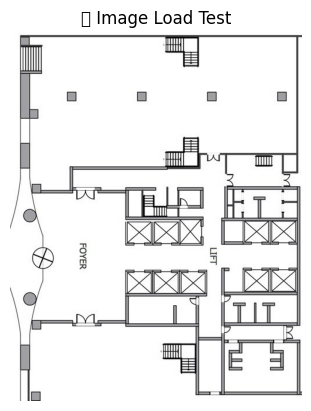

In [30]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(train_samples[0]["file_name"])
if img is None:
    print("❌ Image not found or unreadable.")
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("✅ Image Load Test")
    plt.show()

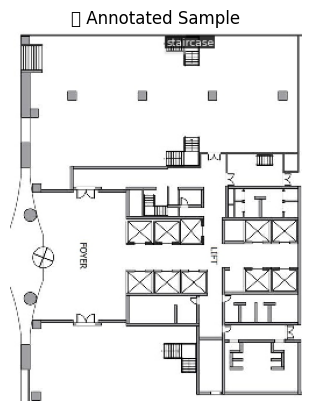

In [31]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

metadata = MetadataCatalog.get("staircase_train")
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(train_samples[0])

plt.imshow(vis.get_image())
plt.axis("off")
plt.title("✅ Annotated Sample")
plt.show()

WARNING [08/20 07:46:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/20 07:46:29 d2.data.datasets.coco]: Loaded 444 images in COCO format from /content/staircase_dataset/StaircaseDetection/train_coco.json


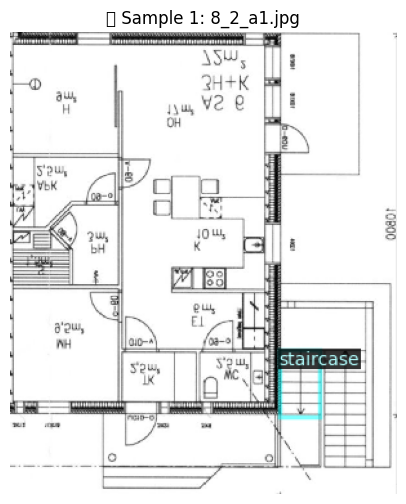

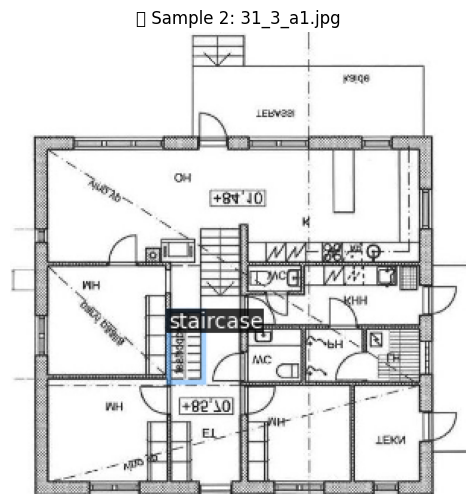

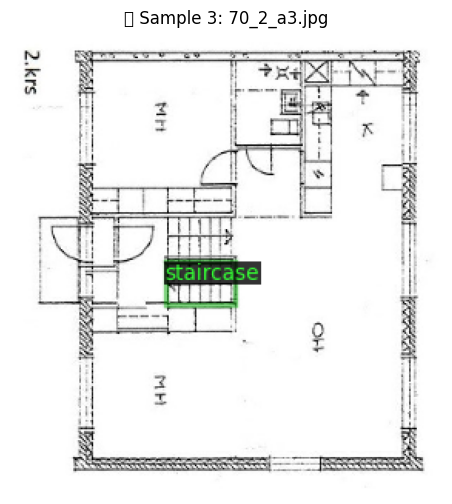

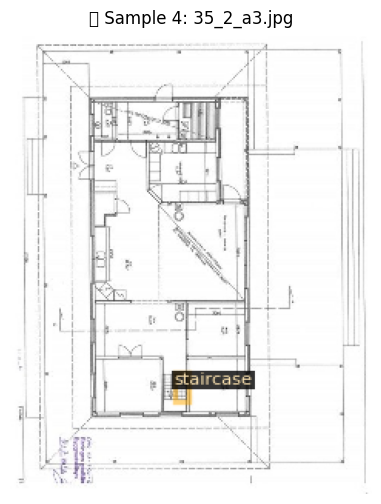

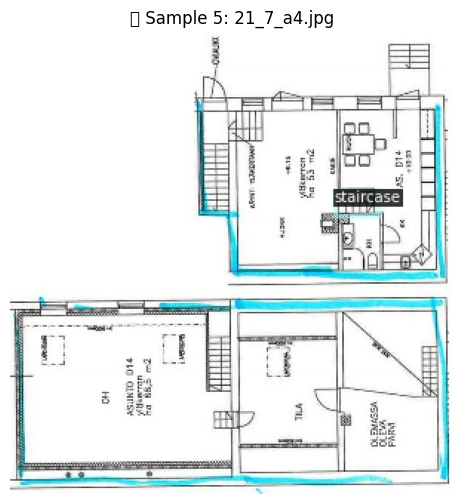

In [33]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

# Load dataset and metadata
samples = DatasetCatalog.get("staircase_train")
metadata = MetadataCatalog.get("staircase_train")

# Shuffle and select N samples
N = 5  # You can increase this if needed
random_samples = random.sample(samples, min(N, len(samples)))

# Visualize each sample
for i, sample in enumerate(random_samples):
    img = cv2.imread(sample["file_name"])
    if img is None:
        print(f"❌ Sample {i+1}: Image not found at {sample['file_name']}")
        continue

    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(sample)

    plt.figure(figsize=(8, 6))
    plt.imshow(vis.get_image())
    plt.axis("off")
    plt.title(f"✅ Sample {i+1}: {sample['file_name'].split('/')[-1]}")
    plt.show()

In [34]:
# Create configs folder
!mkdir -p configs/COCO-Detection

# Download Faster R-CNN config
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml -P configs/COCO-Detection/

--2025-08-20 07:47:03--  https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193 [text/plain]
Saving to: ‘configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml’

faster_rcnn_R_50_FP 100%[===================>]     193  --.-KB/s    in 0s      

2025-08-20 07:47:03 (13.4 MB/s) - ‘configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml’ saved [193/193]



In [35]:
import torch

# Download Faster R-CNN weights from Torchvision
torch.hub.download_url_to_file(
    'https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth',
    'fasterrcnn_resnet50_fpn_coco.pth'
)

100%|██████████| 160M/160M [00:00<00:00, 371MB/s]


In [36]:
!mkdir -p configs
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/Base-RCNN-FPN.yaml -P configs/

--2025-08-20 07:47:10--  https://raw.githubusercontent.com/facebookresearch/detectron2/main/configs/Base-RCNN-FPN.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318 (1.3K) [text/plain]
Saving to: ‘configs/Base-RCNN-FPN.yaml’

Base-RCNN-FPN.yaml  100%[===================>]   1.29K  --.-KB/s    in 0s      

2025-08-20 07:47:10 (84.3 MB/s) - ‘configs/Base-RCNN-FPN.yaml’ saved [1318/1318]



In [41]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ("staircase_train",)
cfg.DATASETS.TEST = ("staircase_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only staircase

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00005
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []  # No LR decay

cfg.OUTPUT_DIR = "./output/staircase_frcnn"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [32]:
cfg.MODEL.DEVICE = "cpu"

In [42]:
from detectron2.engine import DefaultTrainer

trainer = DefaultTrainer(cfg)
trainer.train()

[08/20 07:52:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [43]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # adjust as needed

predictor = DefaultPredictor(cfg)

[08/20 07:57:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/staircase_frcnn/model_final.pth ...


[08/20 09:01:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/staircase_frcnn/model_final.pth ...
WARNING [08/20 09:01:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/20 09:01:34 d2.data.datasets.coco]: Loaded 444 images in COCO format from /content/staircase_dataset/StaircaseDetection/val_coco.json


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


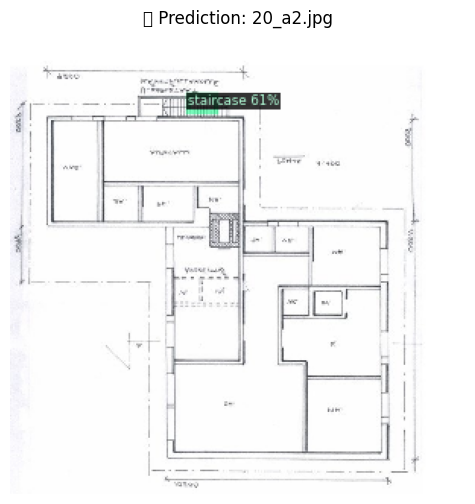

In [85]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

# Load trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

# Access registered validation dataset
dataset_dicts = DatasetCatalog.get("staircase_val")  # Use your actual registered name
metadata = MetadataCatalog.get("staircase_val")

# Pick a random sample
sample = random.choice(dataset_dicts)
image_path = sample["file_name"]
image = cv2.imread(image_path)

if image is None:
    raise ValueError(f"❌ Failed to load image: {image_path}")

# Run inference
outputs = predictor(image)

# Visualize predictions
v = Visualizer(image[:, :, ::-1], metadata, scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display
plt.figure(figsize=(10, 6))
plt.imshow(out.get_image())
plt.axis("off")
plt.title(f"🔍 Prediction: {image_path.split('/')[-1]}")
plt.show()

In [47]:
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import os

def validate_batch(cfg, batch_size=8, output_dir="val_samples"):
    os.makedirs(output_dir, exist_ok=True)
    val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
    metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

    for idx, batch in enumerate(val_loader):
        for i, sample in enumerate(batch):
            img = sample["image"].permute(1, 2, 0).cpu().numpy()
            annos = sample["instances"].to("cpu")
            v = Visualizer(img, metadata=metadata, scale=1.0)
            vis = v.draw_instance_predictions(annos)
            out_path = os.path.join(output_dir, f"val_{idx}_{i}.jpg")
            cv2.imwrite(out_path, vis.get_image())

        if idx >= batch_size - 1:
            break

    print(f"✅ Saved {batch_size * len(batch)} validation samples to '{output_dir}'")

In [50]:
import os
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Paths
input_dir = "/content/staircase_dataset/StaircaseDetection/images"
val_txt_path = "/content/staircase_dataset/StaircaseDetection/val.txt"
output_dir = "/content/staircase_inference_results"
os.makedirs(output_dir, exist_ok=True)

# Metadata from registered dataset
metadata = MetadataCatalog.get("staircase_val")  # Update if your dataset name differs

# Loop through validation images
for img_name in os.listdir(input_dir):
    if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(input_dir, img_name)
        im = cv2.imread(img_path)

        # Run inference
        outputs = predictor(im)
        instances = outputs["instances"].to("cpu")

        # Filter predictions by confidence threshold
        high_conf_preds = instances[instances.scores > 0.7]

        # Visualize predictions
        visualizer = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0)
        vis_output = visualizer.draw_instance_predictions(high_conf_preds)

        # Save visualized image
        save_path = os.path.join(output_dir, img_name)
        cv2.imwrite(save_path, vis_output.get_image()[:, :, ::-1])

print(f"✅ Inference completed! Visual results saved in: {output_dir}")

✅ Inference completed! Visual results saved in: /content/staircase_inference_results


In [58]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Create evaluator for your registered validation dataset
evaluator = COCOEvaluator("staircase_val_patched", cfg, False, output_dir="./output/")

# Build validation dataloader
val_loader = build_detection_test_loader(cfg, "staircase_val_patched")

# Run evaluation
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Print results
print("📊 Evaluation Results:")
for metric, value in results["bbox"].items():
    print(f"{metric}: {value:.4f}")

WARNING [08/20 08:45:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [08/20 08:45:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/20 08:45:16 d2.data.datasets.coco]: Loaded 444 images in COCO format from /content/staircase_dataset/StaircaseDetection/val_coco_patched.json
[08/20 08:45:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/20 08:45:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/20 08:45:16 d2.data.common]: Serializing 444 elements to byte tensors and concatenating them all ...
[08/20 08:45:16 d2.data.common]: Serialized dataset takes 0.12 MiB
[08/20 08:45:16 d2.evaluation.evaluator]: Start inference on 444 batches
[08/

In [53]:
import json

json_path = "/content/staircase_dataset/StaircaseDetection/val_coco.json"

with open(json_path, "r") as f:
    data = json.load(f)

# Add missing 'info' field if not present
if "info" not in data:
    data["info"] = {
        "description": "Staircase Detection Dataset",
        "version": "1.0",
        "year": 2025,
        "contributor": "Anu",
        "date_created": "2025-08-20"
    }

# Save patched file
patched_path = json_path.replace(".json", "_patched.json")
with open(patched_path, "w") as f:
    json.dump(data, f)

print(f"✅ Patched annotation file saved to: {patched_path}")


✅ Patched annotation file saved to: /content/staircase_dataset/StaircaseDetection/val_coco_patched.json


In [57]:
register_coco_instances("staircase_val_patched", {}, patched_path, image_dir)